# Iterative Inpaint Test

In [1]:
import os

import random
from IPython.display import display
from pathlib import Path
from typing import Tuple, Dict, List, Any
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.utils import save_image

In [2]:
###############################
# Dataset pipeline parameters #
###############################
num_workers = 2
ngpu = 1
batch_size = 64


## Plot Utils

In [3]:
from PIL import Image, ImageSequence

def create_grid(images, grid_size, cell_size=(200, 200), padding=10, background_color=(255, 255, 255)):
    """
    Create a grid of PIL images.

    Parameters:
    - images: List of PIL images.
    - grid_size: Tuple representing the number of rows and columns in the grid.
    - cell_size: Tuple representing the size of each cell in the grid.
    - padding: Integer representing the padding between cells.
    - background_color: Tuple representing the RGB color of the background.

    Returns:
    - A PIL image representing the grid of images.
    """
    # Calculate the size of the final grid image
    grid_width = grid_size[1] * (cell_size[0] + padding) - padding
    grid_height = grid_size[0] * (cell_size[1] + padding) - padding

    # Create a blank image with the specified background color
    grid_image = Image.new('RGB', (grid_width, grid_height), background_color)

    # Paste each image into its corresponding position in the grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if i * grid_size[1] + j < len(images):
                # Calculate the position to paste the current image
                x_position = j * (cell_size[0] + padding)
                y_position = i * (cell_size[1] + padding)

                # Resize the image to fit into the cell
                resized_image = images[i * grid_size[1] + j].resize(cell_size, Image.LANCZOS)

                # Paste the resized image into the grid
                grid_image.paste(resized_image, (x_position, y_position))

    return grid_image

def create_gif(images, gif_path, duration=100, loop=0):
    """
    Create a GIF from a list of PIL images.

    Parameters:
    - images: List of PIL images.
    - gif_path: Path to save the resulting GIF.
    - duration: Duration (in milliseconds) for each frame.
    - loop: Number of loops (0 for infinite loop).

    Returns:
    - None
    """
    # Save the first image to initialize the GIF
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        optimize=False,
        duration=duration,
        loop=loop
    )


class TestDataset(Dataset):
    def __init__(self, image_list, transform=None):
        """
        TestDataset constructor.

        Args:
            image_list (list): A list of PIL images.
            transform (callable, optional): A transform to be applied to each image.
                Default is None.
        """
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):

        if self.transform:
            image = self.transform(self.image_list[idx])

        return image

## GDrive connection

In [4]:
GDRIVE = True
# accessing GDrive preprocessed dataset folder
if GDRIVE:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

# accessing dataset folder and printing files contained in it
os.chdir('./gdrive/MyDrive/AII Project/experiments-synthetic-generation-clinical-skin-images-main')
!ls

Mounted at /content/gdrive/
 crops		     evaluation		      lightning_logs   outputs-gan    VAE_128_GANloss
 dataset	     generate_images.ipynb    logs	       saved_models
'Dataset Analysis'   GLIDE_256.ipynb	      low_contrast     test_images
 DCGAN_128.ipynb     glide_generated_images   Old	       VAE_128


## Original Dataset import

In [5]:
class TanhRescaler(object):
    def __call__(self, input_data):
        # Assuming input_data is a PyTorch tensor
        transformed_data = input_data * 2 - 1
        return transformed_data

class MaskPairDataset(Dataset):
    '''
    Custom PyTorch dataset class for handling paired image-mask data.

    Args:
        base_folder (Path): The base folder containing the image and mask pairs.
        transforms (callable, optional): Transforms to be applied to the input images. Default is None.
        mask_transforms (callable, optional): Transforms to be applied to the masks. Default is None.
        suffix (str, optional): The suffix added to image filenames to obtain corresponding mask filenames. Default is "_mask".
        is_mask_rgb (bool, optional): Flag indicating whether the masks are in RGB format. Default is False.
        mask (bool, optional): Flag indicating whether the dataset includes masks. Default is False.

    Attributes:
        transforms (callable): Transforms to be applied to the input images.
        mask_transforms (callable): Transforms to be applied to the masks.
        is_mask_rgb (bool): Flag indicating whether the masks are in RGB format.
        mask (bool): Flag indicating whether the dataset includes masks.
        img_list (list): List of image file paths.
        paired_data (list): List of paired image and mask file paths.

    Methods:
        __len__(self) -> int:
            Returns the total number of paired image-mask data in the dataset.

        __getitem__(self, index) -> Dict:
            Retrieves an item (image and its corresponding mask) by index.
    '''

    def __init__(self, base_folder : Path,
                 transforms = None,
                 mask_transforms = None,
                 suffix:str = "_mask",
                 is_mask_rgb:bool = False,
                 mask=False):

        self.transforms = transforms
        self.mask_transforms = mask_transforms
        self.is_mask_rgb = is_mask_rgb
        self.mask = mask
        self.img_list = []

        # Get all png images in the folder
        self.img_list = base_folder.glob("*.png")
        # Remove the masks
        self.img_list = [img for img in self.img_list if "mask" not in img.name]

        # Create the pairs
        self.paired_data = []

        if self.mask:
          for img in self.img_list:
              supposed_mask = base_folder / (img.stem + suffix + ".png")
              if supposed_mask.is_file():
                  self.paired_data.append((img, supposed_mask))

    def __len__(self) -> int:
        '''
        Returns the total number of paired image-mask data in the dataset.

        Returns:
            int: Length of paired data.
        '''
        if self.mask:
          return len(self.paired_data)
        else:
          return len(self.img_list)


    def __getitem__(self, index) -> Dict:
        '''
        Retrieves an item (image and its corresponding mask) by index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            Dict: A dictionary containing 'img' (image) and 'mask' (corresponding mask).
        '''

        if self.mask:
            img_path, mask_path = self.paired_data[index]
            img = Image.open(img_path).convert("RGB")
            if self.is_mask_rgb:
                mask = Image.open(mask_path).convert("RGB")
            else:
                mask = Image.open(mask_path).convert("L")
        else:
            img_path = self.img_list[index]
            img = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transforms:
            # Make sure that random transforms to both image and mask behave in the same way
            seed = np.random.randint(2147483647)

            random.seed(seed)
            th.manual_seed(seed)
            img = self.transforms(img)

            random.seed(seed)
            th.manual_seed(seed)

        if self.mask_transforms and self.mask:
                mask = self.transforms(mask)

        if self.mask:
            return {"img":img, "mask":mask}
        else:
            return {"img":img}

In [7]:
# Building the dataset and dataloader (just rerun in case of errors for input/output)

base_folder = Path("./crops")

transforms_ = transforms.Compose([ToTensor()])

dataset = MaskPairDataset(base_folder, transforms=transforms_, suffix="_mask2", is_mask_rgb=True)#, img_norm=Normalize(mean=means, std=stds), mask_norm=Normalize(mean=[0.5], std=[0.5]))

print('This dataset contains {} samples, with dimension {}'.format(len(dataset),dataset[0]['img']))


This dataset contains 11994 samples, with dimension tensor([[[0.4431, 0.4431, 0.4471,  ..., 0.4784, 0.4706, 0.4706],
         [0.4510, 0.4510, 0.4549,  ..., 0.4863, 0.4824, 0.4745],
         [0.4627, 0.4471, 0.4431,  ..., 0.4784, 0.4784, 0.4667],
         ...,
         [0.5490, 0.5608, 0.5529,  ..., 0.5490, 0.5490, 0.5569],
         [0.5451, 0.5529, 0.5490,  ..., 0.5451, 0.5451, 0.5529],
         [0.5373, 0.5412, 0.5373,  ..., 0.5451, 0.5412, 0.5529]],

        [[0.3373, 0.3373, 0.3333,  ..., 0.3843, 0.3765, 0.3765],
         [0.3412, 0.3412, 0.3412,  ..., 0.3922, 0.3765, 0.3686],
         [0.3529, 0.3373, 0.3294,  ..., 0.3843, 0.3843, 0.3725],
         ...,
         [0.4627, 0.4745, 0.4667,  ..., 0.4471, 0.4471, 0.4549],
         [0.4588, 0.4667, 0.4588,  ..., 0.4431, 0.4431, 0.4510],
         [0.4471, 0.4510, 0.4471,  ..., 0.4431, 0.4510, 0.4510]],

        [[0.2706, 0.2706, 0.2784,  ..., 0.3373, 0.3294, 0.3294],
         [0.2863, 0.2863, 0.2863,  ..., 0.3451, 0.3333, 0.3255],
      

In [8]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

# Decide which device we want to run on
device = th.device("cuda:0" if (th.cuda.is_available() and ngpu > 0) else "cpu")


# Create the dataloader
dataloader = th.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         pin_memory = th.cuda.is_available(),
                                         shuffle=True, num_workers=num_workers)

## GLIDE-generated images import

### Visualize images generated by the model

In [9]:
results_folder = "glide_generated_images/"
samples_index = list(range(0,20))
runs_index = [0] # list(range(0,5))
# image with index 0 is the original one
diffusion_steps = list(range(0,12))
transform = transforms.Compose([ ToTensor(), TanhRescaler() ])
img_pseudonym = 'fake_misleases'
include_original_img = True


test_samples = []
original_imgs = []

for index in samples_index:
  for run in runs_index:
    for step in diffusion_steps:
        if step == 0 and (not include_original_img):
            image = Image.open(results_folder+f'sample_{index}/run{run:03d}/{img_pseudonym}{step:03d}.png')
            img_tensor = transform(image)
            original_imgs.append(image)
        else:
            image = Image.open(results_folder+f'sample_{index}/run{run:03d}/{img_pseudonym}{step:03d}.png')
            img_tensor = transform(image)
            test_samples.append(image)

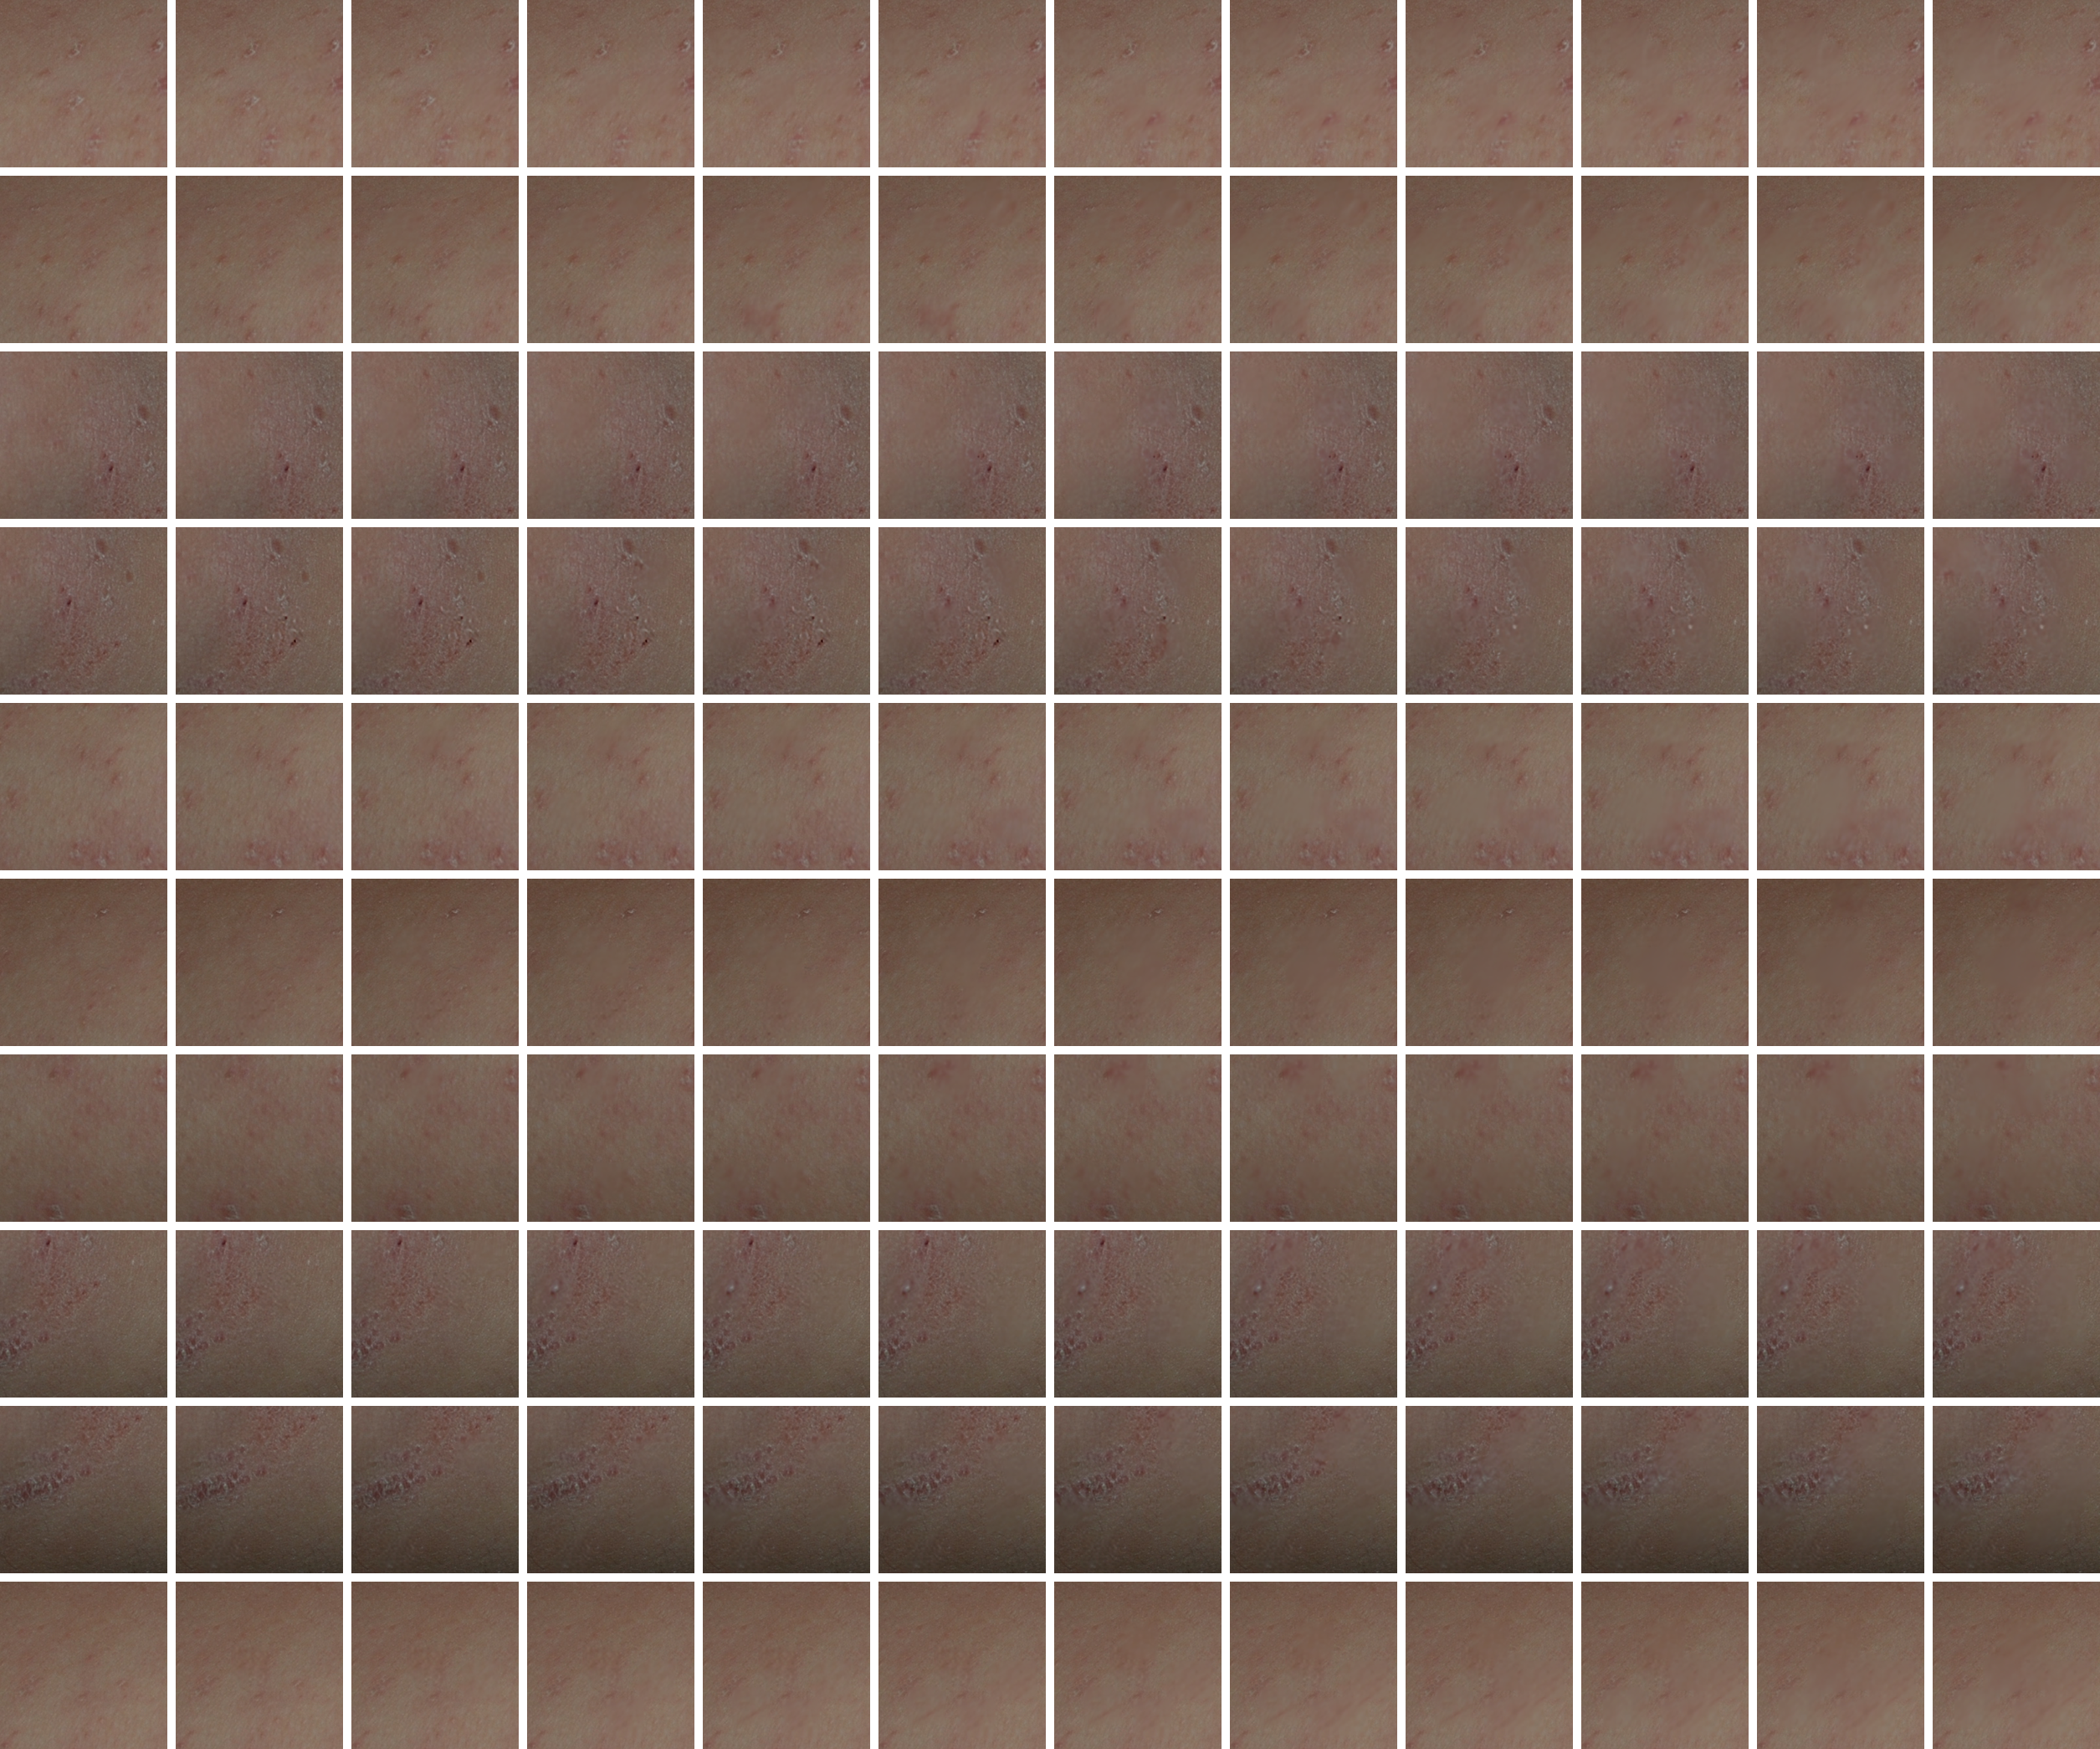

In [10]:
# diffusion steps to visualize

create_grid(images = test_samples[:len(diffusion_steps)*10], grid_size = (10,len(diffusion_steps)))


In [11]:
# creating a gif for sample i
sample_index = 5
output_file = './evaluation/output.gif'
create_gif(test_samples[(sample_index*len(diffusion_steps)): (sample_index*len(diffusion_steps) + len(diffusion_steps))], output_file, duration=100, loop=0)

### Import test images

In [12]:
results_folder = "glide_generated_images/"
samples_index = list(range(0,20))
runs_index = list(range(0,5))
# image with index 0 is the original one
diffusion_steps = [0,1]#list(range(0,3))
img_pseudonym = 'fake_misleases'
include_original_img = False


test_samples = []
original_imgs = []

for index in samples_index:
  for run in runs_index:
    for step in diffusion_steps:
        if step == 0 and (not include_original_img):
            image = Image.open(results_folder+f'sample_{index}/run{run:03d}/{img_pseudonym}{step:03d}.png')
            original_imgs.append(image)
        else:
            image = Image.open(results_folder+f'sample_{index}/run{run:03d}/{img_pseudonym}{step:03d}.png')
            test_samples.append(image)


# Define a transformation (you can customize this based on your needs)
transform = transforms.Compose([
    ToTensor()
])

# Create an instance of the custom dataset
test_dataset = TestDataset(test_samples, transform)

# Create a data loader
test_fakeimgs_loader = th.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
print(f'{len(test_samples)} images produced by the model were imported, in PIL format')

100 images produced by the model were imported, in PIL format


## FID Evaluation

In [14]:
!pip install pip install torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.7 MB/s eta 0:00:00


In [26]:
# FID evaluation
# Take all training examples, I know it's overfitting but w.e.
# Instantatiate FID object
from torchmetrics.image.fid import FrechetInceptionDistance
import tqdm


fid = FrechetInceptionDistance(normalize=True).to(device)

for i, fake_imgs_batch in enumerate(tqdm.tqdm(test_fakeimgs_loader)):
    fid.update(fake_imgs_batch.to(device), real=False)
    real_img = next(iter(dataloader))["img"].to(device)
    fid.update(real_img, real=True)

print(f"FID:{fid.compute()}")

100%|██████████| 2/2 [02:17<00:00, 68.67s/it]


FID:154.00576782226562
